# Note
This interactive notebook contains the code for Protein-Protein interaction prediction context which was adapted from the MHC-Peptide context. Full scripts are located in the github here: [link]

# Imports and Data

In [2]:
import pandas as pd # For data handling
import numpy as np
import os
import random
random.seed(42)
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import sklearn
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, auc
import argparse
import wandb
import pickle
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

os.chdir('/ix/djishnu/Jane/ppis/finals/mats/mutations/SW_natflip')
df = pd.read_csv('NPflip_nature_muts_tracker_shuffled.csv')
df.shape

(3422, 9)

In [4]:
df.head()

,Mutation,Y2H_score,data,Mutation UPID,Interactor UPID,old_index,Position,Mutated Seq (unless WT),Interactor Seq
0,S357A,0.0,nature,Q9UK11,Q9NQZ6,1433,357,MTMSKEAVTFKDVAVVFTEEELGLLDLAQRKLYRDVMLENFRNLLS...,MADEQEIMCKLESIKEIRNKTLQMEKIKARLKAEFEALESEERHLK...
1,M448T,0.0,NP,Q5JVL4,Q04864,559,448,MVSNPVHGLPFLPGTSFKDSTKTAFHRSQTLSYRNGYAIVRRPTVG...,MASGAYNPYIEIIEQPRQRGMRFRYKCEGRSAGSIPGEHSTDNNRT...
2,R433W,0.0,nature,P28799,Q6PEX3,1272,433,MWTLVSWVALTAGLVAGTRCPDGQFCPVACCLDPGGASYSCCRPLL...,MSCPNYCSGNSNSGSLRTSRHIPLTSIDLCPTSVSCGDVLYLPTSS...
3,R8Q,0.0,nature,Q9UBB9,Q9NV31,1615,8,MSLSHLYQDGEGRIDDDDDERENFEITDWDLQNEFNPNRQRHWQTK...,MVRKLKFHEQKLLKQVDFLNWEVTDHNLHELRVLRRYRLQRREDYT...
4,A9D,1.0,NP,P28799,Q8N6T3,741,9,MWTLVSWVALTAGLVAGTRCPDGQFCPVACCLDPGGASYSCCRPLL...,MASPRTRKVLKEVRVQDENNVCFECGAFNPQWVSVTYGIWICLECS...


# Language Generation
Packages needed:
- pandas
- numpy
- random
- gensim.models.doc2vec's Doc2Vec and TaggedDocument

## Delta Grantham Dict

In [6]:
AA_scores = {'A':8.1,'R':10.5,'N':11.6,'D':13.0,'C':5.5,'E':12.3,'Q':10.5,'G':9.0,'H':10.4,'I':5.2,
            'L':4.9,'K':11.3,'M':5.7,'F':5.2,'P':8.0,'S':9.2,'T':8.6,'W':5.4,'Y':6.2,'V':5.9} # Grantham score
AAs = list(AA_scores.keys())
aa_score_dict = {} 
for i in range(len(AAs)): # create all pairs of AAs
    for j in range(len(AAs)-i):
        AA_pair = AAs[i]+AAs[j+i]
        AA_pair_score = round(abs(AA_scores[AAs[i]]-AA_scores[AAs[j+i]])) # take rounded, absolute value of the difference of scores
        aa_score_dict[AA_pair] = AA_pair_score

# Save dictionary
# delta_grantham_dict = aa_score_dict
# with open('delta_grantham_dict.pickle', 'wb') as handle: 
#     pickle.dump(delta_grantham_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load Dictionary
with open('delta_grantham_dict.pickle', 'rb') as handle:
    delta_grantham_dict = pickle.load(handle)

In [7]:
# delta_grantham_dict

## Window Encodings

### README
get_window_encodings() takes a pandas dataframe where each row represents a protein-protein interaction with an position of mutation (integers) column, mutated sequence column (string), and interactor sequence column (string). It also takes a window_k parameter (integer) which determines the number of amino acids of each side of the mutation to include in the mutation window. The scoring method is input as a dictionary with interacting amino acids (str) as keys and the absolute value of the rounded difference of the scores (Ex. 'AR':2). The padding score is also a parameter (integer) and should be based on the range of score differences. 

The function returns a list of score encodings strings that each represent a PPI. The ends of the encodings include padding from the sliding window process. These encodings will be broken into k-mers for the embedding model.

In [16]:
def get_window_encodings(df, window_k=3, pos_colname='Position', mutseq_colname='Mutated Seq (unless WT)', intseq_colname='Interactor Seq', aa_score_dict=aa_score_dict, padding_score=9): # Takes df (mut/int sequences and mutation position) and window_k (# AA's on each side of the mutation position)
    total_encodings = [] # Master list of encodings
    for i in tqdm(df.index): # Iterate through protein pairs
        pos = df[pos_colname].iloc[i]-1 # find mutation position for window
        mut_window = df[mutseq_colname].iloc[i][pos-window_k:pos+window_k+1] # Create sliding window
        interactor = df[intseq_colname].iloc[i] # Get interactor sequence
        PPI_encoding = '' # For each PPI
        its = 0 # Tracks sliding window position
        for j in range(len(interactor)): # For the entire length of the interactor
            window_scores = '' # Saves the scores between window-interactor at the 'its' position
            for k in range(len(mut_window)): # At each positon of the interactor ('its'), align mutant window and find the score differences
                try: # If 'its' is at the end of the interactor, the window is hanging off end (padding)
                    pair = mut_window[k]+interactor[k+its] 
                    try: # No directionality, A:B = B:A
                        score = aa_score_dict[pair]
                    except: # No directionality, flip pair if not in dictionary
                        pair = pair[::-1] 
                        score = aa_score_dict[pair]
                except: # If not a pair, its padding (end of interactor)
                    pair = None
                    score = padding_score # Padding score is 9
                window_scores = window_scores + str(score) # Add score to running string
            its +=1 # Slide down a position on the interactor
            PPI_encoding = PPI_encoding + str(window_scores) # Add to final string for interaction
        total_encodings.append(PPI_encoding) # Add to list for all interactions
    return total_encodings # List of encodings for each PPI

In [17]:
window_encodings = get_window_encodings(df,window_k=3, pos_colname='Position', mutseq_colname='Mutated Seq (unless WT)', intseq_colname='Interactor Seq', aa_score_dict=aa_score_dict, padding_score=9)
# window_encodings[0] # last SW 2999999 (2*window_k+1)

100%|██████████| 3422/3422 [00:06<00:00, 533.32it/s]


## K-Mers

### README
get_kmers_str() takes the encoding scores from get_window_encodings(), a k parameter that represents the k-mer size (integer), a shuffle option (True/False), percent_vocab ((0,1], float) which randomly selects a percentage of the k-mers to return if not 1, and the same padding_score (integer) from get_window_encodings(). 


This function returns a list of lists of overlapping k-mers of specified size k, removing k-mers of only padding. Each list of k-mers are specific to each of the PPIs.

In [18]:
def get_kmers_str(encoding_scores, k=3, shuffle=False, percent_vocab=1, padding_score=9):
    padding = {str(padding_score)} 
    for i in range(k): # Makes a set of padding scores that will be removed from the final k-mers
        padding.add(str(9)*(i+1)) # {'9','99','999'...}
    kmers = [] # Master list of k-mers
    for ppi_score in tqdm(encoding_scores): # For each PPI encoding
        int_kmers = [] # K-mers specific to PPI
        for j in range(len(ppi_score)): # Iterate over the PPI encoding
            kmer = ppi_score[j:j+k] # Slice k-mers and sliding over
            if kmer in padding: # If K-mer is just padding, don't add it
                pass
            else:
                int_kmers.append(kmer) # Keep non-padding k-mers 
        if shuffle: # Shuffle if specified
            random.shuffle(int_kmers)
        if percent_vocab != 1: # Remove percent vocab is specified
            int_kmers=random.sample(int_kmers,int(len(int_kmers)*percent_vocab)) # Randomly selects %  
        kmers.append(int_kmers) # Append k-mers to master list
    return kmers 

In [19]:
kmers = get_kmers_str(window_encodings, k=3, shuffle=False, percent_vocab=1,  padding_score=9)
len(kmers) # Should be number of interactions

100%|██████████| 3422/3422 [00:02<00:00, 1364.73it/s]


3422

## Get Corpus

### README
get_corpus() takes in the k-mers created in get_kmers_str(). It outputs a Doc2Vec TaggedDocuments entities for each PPI to be used in a Doc2Vec model.

In [20]:
def get_corpus(matrix, tokens_only=False):
    for i in range(len(matrix)): # for each PPI
        yield gensim.models.doc2vec.TaggedDocument(matrix[i],[i]) # Create a tagged document

In [22]:
train_corpus = list(get_corpus(kmers))
# train_corpus[0]

# Embedding Generation
Packages needed:
- gensim.models.doc2vec's Doc2Vec (v 4.2.0)

In [23]:
# Tuned Parameters from WandB
# D2V Training can take a long time, outputs can be loaded in following block
dim = 128
alpha = 0.0223
epochs = 200 
d2v_model = Doc2Vec(vector_size=dim, min_count=1, alpha=alpha)
# d2v_model.build_vocab(train_corpus)
# d2v_model.train(train_corpus, total_examples=d2v_model.corpus_count, epochs=epochs) 
print('d2v training done')

d2v training done


In [24]:
# D2V output - nat and np vecs are trained in D2V together, 
# but embeddings were seperated for training purposes
with open('nat_vecs_seqsimparams.pkl', 'rb') as nat_v:
    nat_vecs = pickle.load(nat_v) # deserialize using load()
nat_labs = np.load('nat_labs_seqsimparams.npy')

with open('np_vecs_seqsimparams.pkl', 'rb') as np_v:
    np_vecs = pickle.load(np_v) # deserialize using load()
np_labs = np.load('np_labs_seqsimparams.npy')

# Classification
Packages needed:
- xgboost's XGBClassifier (v 1.6.1)

### Initializing XGBoost

In [25]:
# Tuned Parameters from WandB
n_estimators = 225
max_depth = 6
learning_rate = 0.186
xgb_cl = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

### Create Example Dataset

In [26]:
# Shuffle dataset to eliminate batch effect
features =  np.array(nat_vecs + np_vecs)
y_true = np.array(list(nat_labs)+list(np_labs))

indices = np.arange(features.shape[0]) 
np.random.shuffle(indices)

features = features[indices]
y_true = y_true[indices]

X_train, X_test, y_train, y_test = train_test_split(features, y_true, test_size=0.2, random_state=42)
print('y test:',Counter(y_test))

y test: Counter({0.0: 506, 1.0: 179})


### Train and Evaluate XGBoost

In [27]:
# Train
xgb_cl.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.186, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=225,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [28]:
# Evaluate
# y_test_permuted = np.random.binomial(n=1, p=0.5, size=[len(y_test)]) # random ys
np.random.seed(42)
y_test_permuted = np.random.binomial(n=1, p=(Counter(y_test)[1.0]/len(y_test)), size=[len(y_test)]) # random ys
print('y test permuted:',Counter(y_test_permuted))

test_pred = xgb_cl.predict(X_test)
pred_proba = xgb_cl.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, pred_proba)

pred_proba_permuted = xgb_cl.predict_proba(X_test)[:,1]
fpr_perm, tpr_perm, _ = metrics.roc_curve(y_test_permuted, pred_proba_permuted)

auc_score = metrics.roc_auc_score(y_test,pred_proba)
print('AUC Score:', auc_score)
f1_score =  metrics.f1_score(y_test,test_pred)
print('F1 Score:', f1_score)
precision = metrics.precision_score(y_test,test_pred)
print('Precision:', precision)
recall = metrics.recall_score(y_test,test_pred)
print('Recall:', recall)

auc_score_perm = metrics.roc_auc_score(y_test_permuted, pred_proba_permuted)
print('Perm Y AUC Score:', auc_score_perm)

y test permuted: Counter({0: 504, 1: 181})
AUC Score: 0.8495373948373706
F1 Score: 0.5663082437275986
Precision: 0.79
Recall: 0.441340782122905
Perm Y AUC Score: 0.49932035429273


### Plot AUC Curve

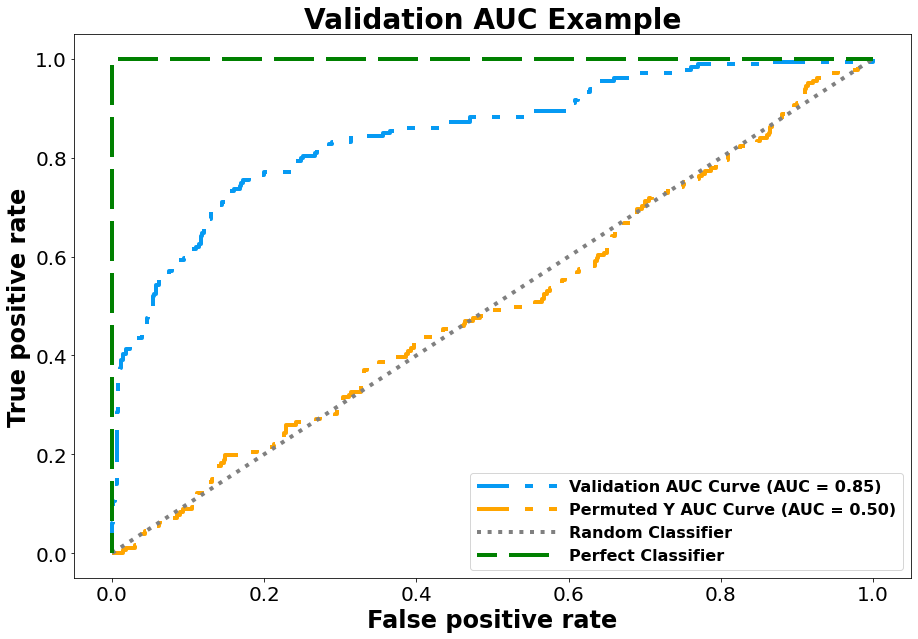

In [29]:
fig = plt.figure(figsize =(15, 10))

plt.plot(fpr, tpr, color='#069AF3', label='Validation AUC Curve (AUC = %0.2f)' % (auc_score), linewidth = 4, dashes=[8, 4, 2, 4, 2, 4])
plt.plot(fpr_perm, tpr_perm, color='tomato', label='Permuted Y AUC Curve (AUC = %0.2f)' % (auc_score_perm), linewidth = 4, dashes=[8, 4, 2, 4, 2, 4])
plt.plot([0, 1], [0, 1], linestyle=':', color='gray', linewidth=4, label='Random Classifier')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=(5, (10, 3)), color='green', linewidth = 4, label='Perfect Classifier')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.title('Validation AUC Example', fontweight='bold', fontsize=28)
plt.xlabel('False positive rate', fontweight='bold', fontsize=24)
plt.ylabel('True positive rate', fontweight='bold', fontsize=24)
plt.legend(loc="lower right", prop={'size': 16, 'weight':'bold'}, handlelength=5)
plt.show()

### Nested Cross Validation

In [31]:
# NCV can take ~20 min, can use the pre-saved DF in next cell!
df = pd.DataFrame(columns=['AUCs','PermYAUCs','F1s','Precisions','Recalls','TPRs','FPRs','FPRperms','TPRperms'])

# number of iterations
outer_loop = 10
inner_loop = 10

all_tts_aucs = []
all_tts_permy_aucs = []
all_tts_f1s = []
all_tts_percisions =[]
all_tts_recalls = []
all_tts_fprs = []
all_tts_tprs = []
all_tts_permy_fprs = []
all_tts_permy_tprs = []

#  make unshuffled dataset
features =  np.array(nat_vecs + np_vecs)
y_true = np.array(list(nat_labs)+list(np_labs))

for o_its in tqdm(range(outer_loop)): # shuffle dataset 
    # shuffle data and change the seed each time
    np.random.seed(o_its)
    
    # create new shuffled indicies
    indices = np.arange(features.shape[0]) 
    np.random.shuffle(indices)
    features = features[indices]
    y_true = y_true[indices]

    # save the scores from AUCs
    tts_aucs = []   
    tts_permy_aucs = []
    tts_f1s = []
    tts_percisions =[]
    tts_recalls = []
    tts_fprs = []
    tts_tprs = []
    tts_permy_fprs = []
    tts_permy_tprs = []
    
    for i_its in range(inner_loop): # shuffle each tts
        # TTS + perm y set
        X_train, X_test, y_train, y_test = train_test_split(features, y_true, test_size=0.2, random_state=i_its) # change seed
        y_test_perm = np.random.binomial(n=1, p=(Counter(y_test)[1.0]/len(y_test)), size=[len(y_test)]) # random ys

        # train XGB
        xgb_cl = XGBClassifier(n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate)
        xgb_cl.fit(X_train,y_train)

        # test XGB + permy
        test_pred = xgb_cl.predict(X_test)
        pred_proba = xgb_cl.predict_proba(X_test)[:,1]
        fpr, tpr, _ = metrics.roc_curve(y_test, pred_proba)
        tts_fprs.append(fpr)
        tts_tprs.append(tpr)

        test_pred_perm = xgb_cl.predict(X_test)
        pred_proba_perm = xgb_cl.predict_proba(X_test)[:,1]
        fpr_perm, tpr_perm, _ = metrics.roc_curve(y_test_perm, pred_proba_perm)
        tts_permy_fprs.append(fpr_perm)
        tts_permy_tprs.append(tpr_perm)

        auc_score = metrics.roc_auc_score(y_test,pred_proba)
        auc_score_perm = metrics.roc_auc_score(y_test_perm,pred_proba_perm)
        f1_score =  metrics.f1_score(y_test,test_pred)
        precision = metrics.precision_score(y_test,test_pred)
        recall = metrics.recall_score(y_test,test_pred)
        
        tts_aucs.append(auc_score)
        tts_permy_aucs.append(auc_score_perm)
        tts_f1s.append(f1_score)
        tts_percisions.append(precision)
        tts_recalls.append(recall)
        
    # Define a common set of FPR values for plotting
    common_fpr = np.linspace(0, 1, 100)
    common_fpr_perm = np.linspace(0, 1, 100)
    interp_tpr = []
    interp_tpr_perm = []
    
    # Interpolate TPR values for each fold
    for i in range(len(tts_fprs)):
        interp_tpr.append(np.interp(common_fpr, tts_fprs[i], tts_tprs[i]))
        interp_tpr_perm.append(np.interp(common_fpr_perm, tts_permy_fprs[i], tts_permy_tprs[i]))
    # Calculate the mean of the interpolated TPR values
    mean_tpr = np.mean(interp_tpr, axis=0)
    mean_tpr_perm = np.mean(interp_tpr_perm, axis=0)

    all_tts_aucs.append(np.mean(tts_aucs))
    all_tts_permy_aucs.append(np.mean(tts_permy_aucs))
    all_tts_f1s.append(np.mean(tts_f1s))
    all_tts_percisions.append(np.mean(tts_percisions))
    all_tts_recalls.append(np.mean(tts_recalls))
    all_tts_fprs.append(common_fpr)
    all_tts_tprs.append(mean_tpr)
    all_tts_permy_fprs.append(common_fpr_perm)
    all_tts_permy_tprs.append(mean_tpr_perm)
    print('Outer Loop #' + str(o_its)+ ' Done')

    list_row = [all_tts_aucs, all_tts_permy_aucs, all_tts_f1s, all_tts_percisions, 
                all_tts_recalls, all_tts_fprs, all_tts_tprs, all_tts_permy_fprs, all_tts_permy_tprs]
    df.loc[len(df)] = list_row

# save data
df['AUCs'] = all_tts_aucs
df['PermYAUCs'] = all_tts_permy_aucs
df['F1s'] = all_tts_f1s
df['Precisions'] = all_tts_percisions
df['Recalls'] = all_tts_recalls
df['FPRs'] = all_tts_fprs
df['TPRs'] = all_tts_tprs
df['FPRperms'] = all_tts_permy_fprs
df['TPRperms'] = all_tts_permy_tprs
df.to_pickle('nested_validation_example.pkl')

 10%|█         | 1/10 [01:52<16:55, 112.89s/it]

Outer Loop #0 Done


 20%|██        | 2/10 [03:46<15:05, 113.20s/it]

Outer Loop #1 Done


 30%|███       | 3/10 [05:38<13:10, 112.92s/it]

Outer Loop #2 Done


 40%|████      | 4/10 [07:31<11:17, 112.87s/it]

Outer Loop #3 Done


 50%|█████     | 5/10 [09:24<09:24, 112.99s/it]

Outer Loop #4 Done


 60%|██████    | 6/10 [11:17<07:31, 112.77s/it]

Outer Loop #5 Done


 70%|███████   | 7/10 [13:09<05:38, 112.74s/it]

Outer Loop #6 Done


 80%|████████  | 8/10 [15:01<03:44, 112.48s/it]

Outer Loop #7 Done


 90%|█████████ | 9/10 [16:53<01:52, 112.31s/it]

Outer Loop #8 Done


100%|██████████| 10/10 [18:45<00:00, 112.57s/it]

Outer Loop #9 Done


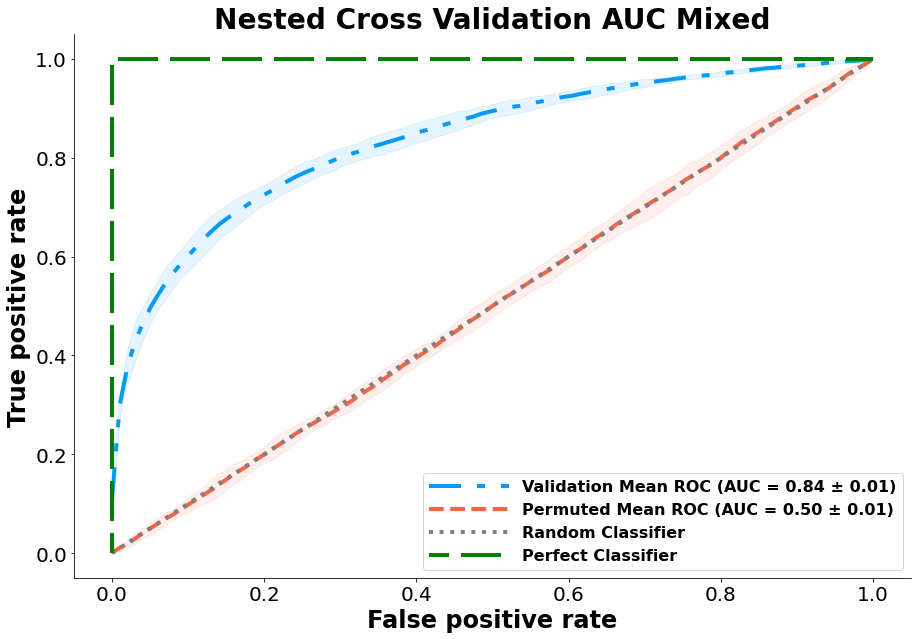

In [2]:
# Load pickle from disk
df = pd.read_pickle('nested_validation_example.pkl')

val_fpr = df.FPRs.values
val_tpr = df.TPRs.values
fpr_perm = df.FPRperms.values
tpr_perm = df.TPRperms.values
mean_auc = np.mean(df.AUCs.values)
std_auc = np.std(df.AUCs.values)
mean_auc_perm = np.mean(df.PermYAUCs.values)
std_auc_perm = np.std(df.PermYAUCs.values)

# Define a common set of FPR values
common_fpr = np.linspace(0, 1, 100)
common_fpr_perm = np.linspace(0, 1, 100)

interp_tpr = []
interp_tpr_perm = []

# Interpolate TPR values for each fold
for i in range(len(val_fpr)):
    interp_tpr.append(np.interp(common_fpr, val_fpr[i], val_tpr[i]))
    interp_tpr_perm.append(np.interp(common_fpr_perm, fpr_perm[i], tpr_perm[i]))

# Calculate the mean and standard deviation of the interpolated TPR values
mean_tpr = np.mean(interp_tpr, axis=0)
std_tpr = np.std(interp_tpr, axis=0)
mean_tpr_perm = np.mean(interp_tpr_perm, axis=0)
std_tpr_perm = np.std(interp_tpr_perm, axis=0)

# Create the plot
fig = plt.figure(figsize =(15, 10))
    
plt.plot(common_fpr, mean_tpr, color='#069AF3', label='Validation Mean ROC (AUC = %0.2f \u00B1 %0.2f)' % (mean_auc, 2*std_auc), linewidth = 4, dashes=[8, 4, 2, 4, 2, 4])
plt.fill_between(common_fpr, (mean_tpr - 2*std_tpr), (mean_tpr + 2*std_tpr), color='#069AF3', alpha=0.1)

plt.plot(common_fpr_perm, mean_tpr_perm, color='tomato', label='Permuted Mean ROC (AUC = %0.2f \u00B1 %0.2f)' % (mean_auc_perm, 2*std_auc_perm), linewidth = 4, linestyle='--')
plt.fill_between(common_fpr_perm, (mean_tpr_perm - 2*std_tpr_perm), (mean_tpr_perm + 2*std_tpr_perm), color='tomato', alpha=0.1)

# Customize the plot
plt.plot([0, 1], [0, 1], linestyle=':', color='gray', linewidth=4, label='Random Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
#plt.title('Mean ROC Curve')
#plt.legend(loc='lower right')


plt.plot([0, 0, 1], [0, 1, 1], linestyle=(5, (10, 3)), color='green', linewidth = 4, label='Perfect Classifier')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.title('Nested Cross Validation AUC Mixed', fontweight='bold', fontsize=28)
plt.xlabel('False positive rate', fontweight='bold', fontsize=24)
plt.ylabel('True positive rate', fontweight='bold', fontsize=24)
plt.legend(loc="lower right", prop={'size': 16, 'weight':'bold'}, handlelength=5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

In [5]:
# fig.savefig('nested_val_example.pdf')
